In [1]:
import torch
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import tqdm 
import copy
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import re

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

train["LEN"] = train["POLYLINE"].apply(polyline_to_trip_duration)

In [5]:
train = train.sort_values('TIMESTAMP')

In [6]:
train.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,False,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8...",360
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,False,"[[-8.619894,41.148009],[-8.620164,41.14773],[-...",315
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,False,"[[-8.617599,41.146137],[-8.617581,41.14593],[-...",630


In [4]:
import holidays
from datetime import timedelta
from datetime import datetime

In [5]:
ptholi = holidays.PT()
def ptholiday(x):
    dt = datetime.fromtimestamp(x)
    curr = dt.date()
    # On holiday
    if curr in ptholi:
        return 2
    # One day before or after holiday
    if curr + timedelta(days=1) in ptholi:
        return 1
    # Not holiday
    else:
        return 0

In [9]:
train['HOLIDAY'] = train['TIMESTAMP'].apply(ptholiday)

In [6]:
from datetime import datetime
def parse_time(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

train[["YR", "MON", "DAY", "HR", "WK"]] = train[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [11]:
train[train['MISSING_DATA']==False]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,HOLIDAY,YR,MON,DAY,HR,WK
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,False,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8...",360,0,2013,7,1,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,0,2013,7,1,0,0
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,0,2013,7,1,0,0
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,False,"[[-8.619894,41.148009],[-8.620164,41.14773],[-...",315,0,2013,7,1,0,0
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,False,"[[-8.617599,41.146137],[-8.617581,41.14593],[-...",630,0,2013,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710412,1404172716620000359,B,NaN,61.0,20000359,1404172716,A,False,"[[-8.599248,41.149197],[-8.598645,41.148504],[...",45,0,2014,6,30,23,0
1710511,1404172718620000066,A,2002.0,NaN,20000066,1404172718,A,False,"[[-8.601192,41.181741],[-8.601201,41.181741],[...",45,0,2014,6,30,23,0
1710603,1404172736620000483,C,NaN,NaN,20000483,1404172736,A,False,"[[-8.58609,41.175504],[-8.586351,41.174955],[-...",45,0,2014,6,30,23,0
1710532,1404172754620000518,B,NaN,58.0,20000518,1404172754,A,False,"[[-8.604765,41.16123],[-8.604792,41.161167]]",15,0,2014,6,30,23,0


In [12]:
train = train[train['MISSING_DATA']==False]
train = train.drop(['TRIP_ID', 'DAY_TYPE', 'TIMESTAMP', 'ORIGIN_CALL', 'MISSING_DATA'], axis=1)
#train = train[train['LEN']!=0]
#train['MISSING_DATA'] = train['MISSING_DATA'].replace({True:1, False:0})
train['CALL_TYPE'] = train['CALL_TYPE'].replace({'A':1, 'B':2, 'C':3})
train.loc[train['CALL_TYPE']==1, ['ORIGIN_STAND']] = 0
train.loc[train['CALL_TYPE']==3, ['ORIGIN_STAND']] = -1

In [13]:
train.dropna(inplace=True)

In [14]:
train['TAXI_ID'] = train['TAXI_ID'].apply(lambda x: int(str(x)[-4:]))

In [15]:
train = train.drop(columns=['POLYLINE'])

In [16]:
train.head()

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,LEN,HOLIDAY,YR,MON,DAY,HR,WK
577,3,-1.0,380,360,0,2013,7,1,0,0
3,3,-1.0,520,630,0,2013,7,1,0,0
0,3,-1.0,589,330,0,2013,7,1,0,0
10,3,-1.0,233,315,0,2013,7,1,0,0
64,3,-1.0,360,630,0,2013,7,1,0,0


In [17]:
train.to_csv('cleaned_train.csv')

In [7]:
train = pd.read_csv('cleaned_train.csv', index_col=0)

In [8]:
train.head()

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,LEN,HOLIDAY,YR,MON,DAY,HR,WK
577,3,-1.0,380,360,0,2013,7,1,0,0
3,3,-1.0,520,630,0,2013,7,1,0,0
0,3,-1.0,589,330,0,2013,7,1,0,0
10,3,-1.0,233,315,0,2013,7,1,0,0
64,3,-1.0,360,630,0,2013,7,1,0,0


(array([1.695717e+06, 2.950000e+03, 4.700000e+02, 1.070000e+02,
        6.300000e+01, 3.200000e+01, 1.100000e+01, 2.000000e+00,
        1.000000e+00, 5.000000e+00]),
 array([    0.,  5820., 11640., 17460., 23280., 29100., 34920., 40740.,
        46560., 52380., 58200.]),
 <BarContainer object of 10 artists>)

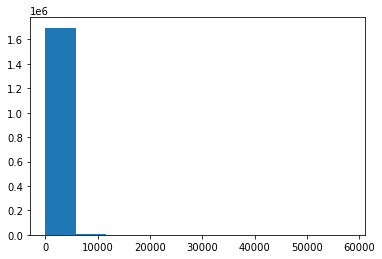

In [64]:
plt.hist(train['LEN'])

In [14]:
mean, std = train["LEN"].mean(), train["LEN"].std()
median = train["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=716.1467742523942 median=600.0 std=685.2098772404441


In [15]:
outlier_threshold = 3
df_trimmed = train[train["LEN"] < mean + outlier_threshold * std]

In [16]:
mean, std = df_trimmed["LEN"].mean(), df_trimmed["LEN"].std()
median = df_trimmed["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=671.684444801256 median=600.0 std=405.31008737807565


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [68]:
s = StandardScaler()
#X = s.fit_transform(df_trimmed.drop(columns=['LEN']))
X = s.fit_transform(df_trimmed.drop(columns=['LEN']))
y = df_trimmed['LEN']

In [71]:
X

array([[ 1.26711975, -0.76896497,  0.15038667, ..., -1.64994686,
        -1.90537997, -1.55412953],
       [ 1.26711975, -0.76896497,  0.81364086, ..., -1.64994686,
        -1.90537997, -1.55412953],
       [ 1.26711975, -0.76896497,  1.14053043, ..., -1.64994686,
        -1.90537997, -1.55412953],
       ...,
       [ 1.26711975, -0.76896497,  0.63835225, ...,  1.62962485,
         1.77489077, -1.55412953],
       [-0.12752294,  2.22587183,  0.8041658 , ...,  1.62962485,
         1.77489077, -1.55412953],
       [ 1.26711975, -0.76896497,  1.46268246, ...,  1.62962485,
         1.77489077, -1.55412953]])

In [72]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.4)

In [73]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1).to(device)

In [74]:
X_train.shape

torch.Size([1008936, 9])

In [75]:
model = nn.Sequential(
    nn.Linear(9, 27),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.BatchNorm1d(27),
    nn.Linear(27, 9),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.BatchNorm1d(9),
    nn.Linear(9, 1),
).to(device)

In [76]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [77]:
from torch.optim.lr_scheduler import StepLR 
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [78]:
save = {'w':None,'history':[],'mse':np.inf}

In [81]:
n_epochs = 20   # number of epochs to run
batch_size = 256  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [82]:
best_mse = save['mse']  # init to infinity
best_weights = save['w']
history_train = []
history_test = []

In [85]:
for epoch in tqdm.tqdm(range(n_epochs)):
    model.train()
    bar = tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True)
    for start in bar:
        # take a batch
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        # forward pass
        y_pred = model(X_batch)
        a = y_pred.cpu().detach().numpy().transpose()[0]
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
    # evaluate accuracy at end of each epoch
    #scheduler.step()
    train_pred = model(X_train)
    history_train.append(float(loss_fn(train_pred, y_train)))
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history_test.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

100%|██████████| 20/20 [04:25<00:00, 13.30s/it]


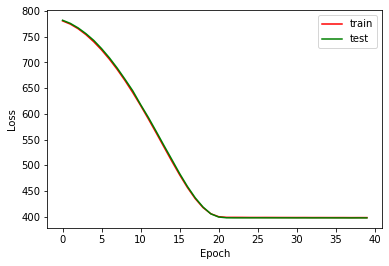

In [86]:
# Plotting both the curves simultaneously
plt.plot(np.sqrt(history_train), color='r', label='train')
plt.plot(np.sqrt(history_test), color='g', label='test')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epoch")
plt.ylabel("Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [87]:
test = pd.read_csv('test.csv')

In [88]:
tid =  test[['TRIP_ID']]

In [89]:
test[["YR", "MON", "DAY", "HR", "WK"]] = test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [90]:
test['HOLIDAY'] = test['TIMESTAMP'].apply(ptholiday)

In [91]:
test = test.drop(['TRIP_ID', 'DAY_TYPE', 'TIMESTAMP', 'ORIGIN_CALL', 'MISSING_DATA'], axis=1)
test['CALL_TYPE'] = test['CALL_TYPE'].replace({'A':1, 'B':2, 'C':3})
test.loc[test['CALL_TYPE']==1, ['ORIGIN_STAND']] = 0
test.loc[test['CALL_TYPE']==3, ['ORIGIN_STAND']] = -1

In [92]:
test['TAXI_ID'] = test['TAXI_ID'].apply(lambda x: int(str(x)[-4:]))

In [93]:
test

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,YR,MON,DAY,HR,WK,HOLIDAY
0,2,15.0,542,2014,8,14,17,3,1
1,2,57.0,108,2014,8,14,17,3,1
2,2,15.0,370,2014,8,14,17,3,1
3,2,53.0,492,2014,8,14,17,3,1
4,2,18.0,621,2014,8,14,17,3,1
...,...,...,...,...,...,...,...,...,...
315,1,0.0,430,2014,12,21,14,6,0
316,2,53.0,20,2014,12,21,14,6,0
317,3,-1.0,207,2014,12,21,14,6,0
318,1,0.0,667,2014,12,21,14,6,0


In [94]:
s = StandardScaler()
X = s.fit_transform(test)
test_input = torch.tensor(X, dtype=torch.float32).to(device)

In [95]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [96]:
torch.save(best_weights, 'weight.pt')

In [97]:
model.load_state_dict(torch.load('weight.pt'))

<All keys matched successfully>

In [98]:
pred = model(test_input).cpu().detach().numpy().transpose()[0]

In [99]:
pred[:10]

array([603.6244 , 585.41064, 600.5973 , 592.3039 , 610.1202 , 651.81384,
       599.9609 , 651.89966, 602.7103 , 600.1412 ], dtype=float32)

In [100]:
tid['TRAVEL_TIME'] = pred

In [101]:
tid

,TRIP_ID,TRAVEL_TIME
0,T1,603.624390
1,T2,585.410645
2,T3,600.597290
3,T4,592.303894
4,T5,610.120178
...,...,...
315,T323,648.340210
316,T324,594.695496
317,T325,584.640015
318,T326,648.340210


(array([19., 78., 53., 83., 21.,  9., 53.,  2.,  0.,  2.]),
 array([563.13617, 584.8678 , 606.59937, 628.33093, 650.06256, 671.7942 ,
        693.52576, 715.2573 , 736.98895, 758.7206 , 780.45215],
       dtype=float32),
 <BarContainer object of 10 artists>)

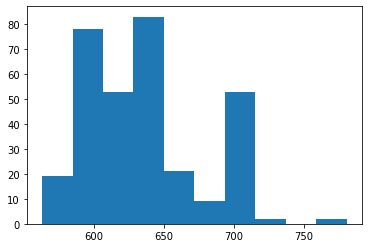

In [102]:
plt.hist(tid['TRAVEL_TIME'])

In [103]:
tid.to_csv('submission3.csv',index=False)

In [104]:
old_tid = pd.read_csv('sampSubmission3.csv')

(array([ 10.,  60.,  58., 115.,  31.,  22.,  16.,   5.,   1.,   2.]),
 array([ 499.83224 ,  557.743796,  615.655352,  673.566908,  731.478464,
         789.39002 ,  847.301576,  905.213132,  963.124688, 1021.036244,
        1078.9478  ]),
 <BarContainer object of 10 artists>)

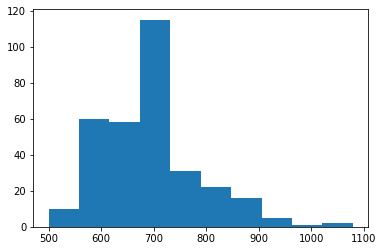

In [105]:
plt.hist(old_tid['TRAVEL_TIME'])